<h1>Analysis of COVID-19 data with PRISM: parameter estimation and SIR modelling</h1>
<h4>by Paolo Milazzo, Department of Computer Science, University of Pisa</h4>

<p>Source code associated with the paper for DataMod 2020</p>

<h2>Modified SIR Model</h2>

<p>Function <code>sir_solver</code> uses <code>odeint</code> to solve an instance of the modified SIR model.</p>

<p>Function <code>ModelSolution</code> calls <code>sir_solver</code> but then returns only the time evolution of the recovered individuals (for comparison with real data)</p>

In both functions:
<ul><li><code>t</code> is an array of timepoints at which the solutions should be
reported;
    <li><code>beta</code> and <code>gamma</code> are standard SIR infection and recovery coefficients;
    <li><code>prev</code> is the coefficient representing the effects of
        prevention measures (aka <em>p_lock</em>);
    <li><code>x0</code> is the array of initial conditions.</ul></p>


In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def sir_solver(t,beta,gamma,prev,x0):

    def sir(x,t,beta,gamma,prev):
        s = x[0]
        i = x[1]
        r = x[2]
        dsdt = -prev*beta*s*i
        didt = prev*beta*s*i - gamma*i
        drdt = gamma*i
        return [dsdt,didt,drdt]

    y = odeint(sir,x0,t,args=(beta,gamma,prev,)) 
    return y

def ModelSolution(t,beta,gamma,prev,x0):
    s = sir_solver(t,beta,gamma,prev,x0)
    #return np.add(s[:,1],s[:,2])
    return s[:,2]

<h2>COVID-19 dataset</h2>
<p>The following code reads csv files with data about the SARS-COV-2 pandemic in Tuscany provinces. The original dataset is made available by "Agenzia Regionale di Sanità (ARS)" and are freely available at <a href="http://dati.toscana.it/dataset/open-data-covid19">http://dati.toscana.it/dataset/open-data-covid19</a>.

In [2]:
import pandas
covid_AR = pandas.read_csv('covid_data/covidars_AR.csv',index_col='giorno',parse_dates=['data'])
covid_FI = pandas.read_csv('covid_data/covidars_FI.csv',index_col='giorno',parse_dates=['data'])
covid_GR = pandas.read_csv('covid_data/covidars_GR.csv',index_col='giorno',parse_dates=['data'])
covid_LI = pandas.read_csv('covid_data/covidars_LI.csv',index_col='giorno',parse_dates=['data'])
covid_LU = pandas.read_csv('covid_data/covidars_LU.csv',index_col='giorno',parse_dates=['data'])
covid_MS = pandas.read_csv('covid_data/covidars_MS.csv',index_col='giorno',parse_dates=['data'])
covid_PI = pandas.read_csv('covid_data/covidars_PI.csv',index_col='giorno',parse_dates=['data'])
covid_PO = pandas.read_csv('covid_data/covidars_PO.csv',index_col='giorno',parse_dates=['data'])
covid_PT = pandas.read_csv('covid_data/covidars_PT.csv',index_col='giorno',parse_dates=['data'])
covid_SI = pandas.read_csv('covid_data/covidars_SI.csv',index_col='giorno',parse_dates=['data'])
covid_Toscana = pandas.read_csv('covid_data/covidars_Toscana.csv',index_col='giorno',parse_dates=['data'])
#print(covid_Toscana)

def get_datapoints(datafile,START,END):
    points_raw = datafile["totale_casi_positivi_ab"].values[(START-1):END]
    #since data are expressed as positive individuals per thousand of abitants
    thousand = lambda x: x/1000  
    points = np.array([ thousand(xi) for xi in points_raw ])
    return points

<h2>Parameter estimation</h2>
<p>Function <code>analysis</code> returns an estimation for <code>beta</code>, <code>gamma</code> and <code>prev</code> (aka <em>p_lock</em>) by fitting real data. Coefficients <code>beta</code> and <code>gamma</code> are estimated by fitting pre-lockdown data, while <code>prev</code> is estimated by fitting data collected during lockdown.</p>

In [3]:
def analysis(points,START,END,LOCKDOWN):

    #could be used to force gamma<MAXGAMMA<=1
    MAXGAMMA = 1 
    #infected in initial conditions is RATIO_IR times the initial
    #ratio of positive individuals in real data
    RATIO_IR = 3 

    def fit_normal(data,t_start,t_end):
        t = np.linspace(t_start,t_end,t_end-t_start+1)
        x0 = [1-(RATIO_IR+1)*data[0],RATIO_IR*data[0],data[0]]
        bounds = (0,[np.inf,MAXGAMMA])
        f = lambda t,beta,gamma: ModelSolution(t,beta,gamma,1,x0) 
        p = curve_fit(f,t,data,bounds=bounds)
        return p

    def fit_lockdown(data,t_start,t_end,beta,gamma,x0):
        t = np.linspace(t_start,t_end,t_end-t_start+1)
        bounds = (0,1)
        f = lambda t,prev: ModelSolution(t,beta,gamma,prev,x0)
        p = curve_fit(f,t,data,bounds=bounds)
        return p
  
    if START < LOCKDOWN and LOCKDOWN <= END:
        points1 = points[:(LOCKDOWN-START+1)] 
        p1=fit_normal(points1,START,LOCKDOWN)
        t = np.linspace(START,LOCKDOWN,LOCKDOWN-START+1)
        x1 = [1-(RATIO_IR+1)*points1[0],RATIO_IR*points1[0],points1[0]]
        y1 = sir_solver(t,p1[0][0],p1[0][1],1,x1)
        x2 = [y1[-1][0],y1[-1][1],y1[-1][2]]
        points2 = points[(LOCKDOWN-START):END]
        p2=fit_lockdown(points2,LOCKDOWN,END,p1[0][0],p1[0][1],x2)
        p = [p1[0][0],p1[0][1],p2[0][0]]    
    else:
        p1=fit_normal(points,START,END)
        p = [p1[0][0],p1[0][1],1]
        
    return p

<h2>Plotting function</h2>
<p>Function <code>plot_resuts</code> plots graph including numerical simulation of the modified SIR model for a given set of coefficients, together with real data points (as dots) in order to visually appreciate the accuracy of data fitting. Moreover, the curve of infected individuals obtained from the modified SIR model is actually a prediction of the number of real infected individual that are <em>&quot;hidden&quot;</em> in the population (see details in the paper).</p>

In [4]:
def plot_results(p,points,province,START,END,LOCKDOWN):
    
    # see RATIO_IR in function analysis. Should have the same value
    RATIO_IR = 3
    
    t = np.linspace(START,END,END-START+1)        
    if START < LOCKDOWN and LOCKDOWN <= END:
        #x1 = [1-points[0],points[0]/2,points[0]/2]
        x1 = [1-(RATIO_IR+1)*points[0],RATIO_IR*points[0],points[0]]
        t1 = np.linspace(START,LOCKDOWN,LOCKDOWN-START+1)    
        y1 = sir_solver(t1,p[0],p[1],1,x1)
        x2 = [y1[-1][0],y1[-1][1],y1[-1][2]]
        t2 = np.linspace(LOCKDOWN,END,END-LOCKDOWN+1)    
        y2 = sir_solver(t2,p[0],p[1],p[2],x2)
        y = np.concatenate([y1,y2[1:]])
    else:
        x0 = [1-points[0],points[0]/2,points[0]/2]
        y = sir_solver(t,p[0],p[1],1,x0)
    plt.plot(t,points,"ro")
    plt.plot(t,y[:,1:])
    plt.ylabel('population ratio')
    plt.xlabel('days')
    plt.title(province + ' data fit and prediction')
    plt.show()
    #uncomment this to save plots as png files
    #plt.savefig('result_' + province + '.png')
    return y
    

<h2>Main script</h2>
<p>Using functions defined above, for each province we estimate parameters for the modified SIR model and plot results of model simulation and data fitting</p>

In [5]:
# days are counted as in the dataset used for parameter estimation
# day 0 is February 24th, 2020 (see the paper for details)
START = 20 # day of start of the observation period
END = 75 # day of end of the observation period
LOCKDOWN = 45 # day in which lockdown effect has been observed


# PARAMETER ESTIMATION

points_AR = get_datapoints(covid_AR,START,END);
p_AR = analysis(points_AR,START,END,LOCKDOWN)

points_FI = get_datapoints(covid_FI,START,END);
p_FI = analysis(points_FI,START,END,LOCKDOWN)

points_GR = get_datapoints(covid_GR,START,END);
p_GR = analysis(points_GR,START,END,LOCKDOWN)

points_LI = get_datapoints(covid_LI,START,END);
p_LI = analysis(points_LI,START,END,LOCKDOWN)

points_LU = get_datapoints(covid_LU,START,END);
p_LU = analysis(points_LU,START,END,LOCKDOWN)

points_MS = get_datapoints(covid_MS,START,END);
p_MS = analysis(points_MS,START,END,LOCKDOWN)

points_PI = get_datapoints(covid_PI,START,END);
p_PI = analysis(points_PI,START,END,LOCKDOWN)

points_PO = get_datapoints(covid_PO,START,END);
p_PO = analysis(points_PO,START,END,LOCKDOWN)

points_PT = get_datapoints(covid_PT,START,END);
p_PT = analysis(points_PT,START,END,LOCKDOWN)

points_SI = get_datapoints(covid_SI,START,END);
p_SI = analysis(points_SI,START,END,LOCKDOWN)


# SHOW PARAMETERS IN A TABLE

pandas.DataFrame([p_AR,p_FI,p_GR,p_LI,p_LU,p_MS,p_PI,p_PO,p_PT,p_SI],
                ["AREZZO","FIRENZE","GROSSETO","LIVORNO","LUCCA","MASSA CARRARA","PISA","PRATO","PISTOIA","SIENA"],
                ["beta","gamma","prev"])



,beta,gamma,prev
AREZZO,0.229077,0.251638,0.994387
FIRENZE,0.145176,0.097258,0.001665
GROSSETO,0.129660,0.143967,0.484480
LIVORNO,0.107488,0.104095,0.316788
LUCCA,0.120929,0.111321,0.004219
MASSA CARRARA,0.102453,0.084308,0.000098
PISA,0.122123,0.127242,0.471045
PRATO,0.131012,0.119207,0.149972
PISTOIA,0.078017,0.099508,0.991238
SIENA,0.076967,0.069997,0.000232


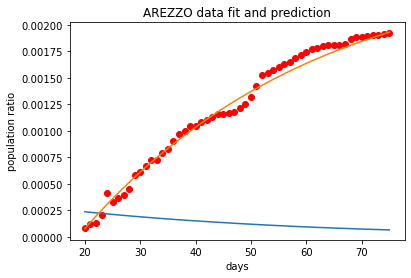

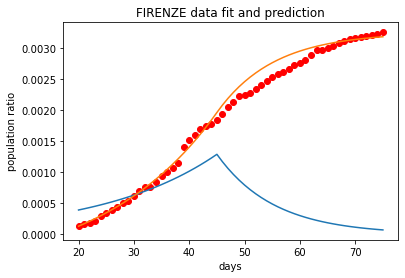

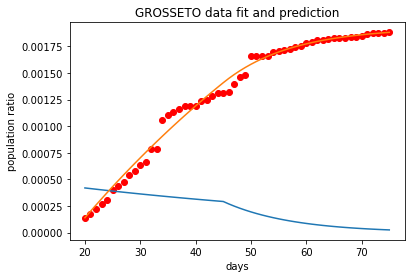

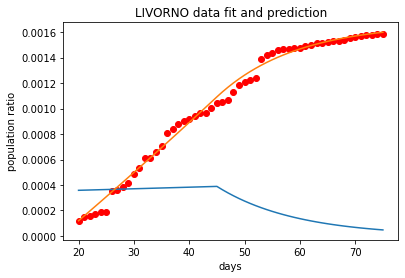

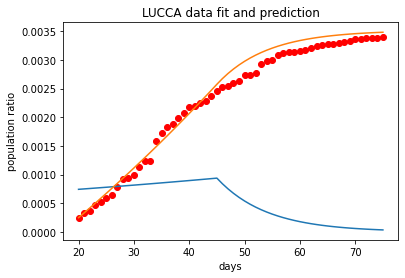

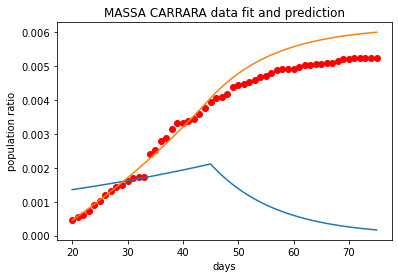

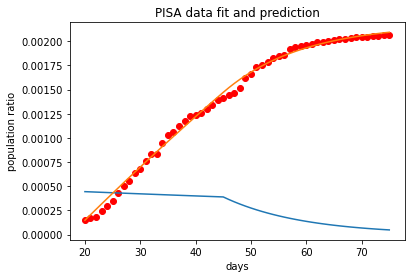

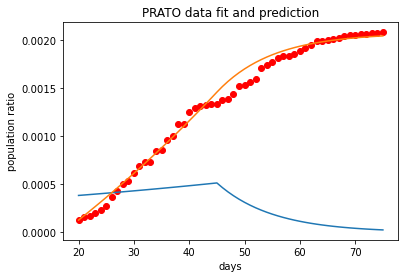

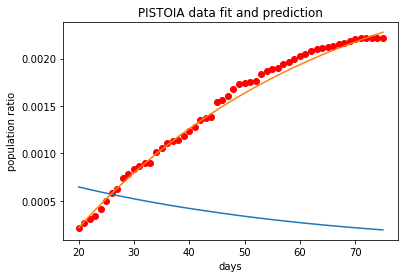

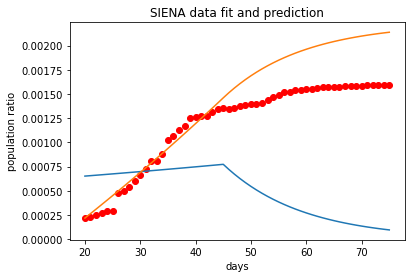

In [6]:
# PLOT DATA FITTING AND SIMULATION RESULTS

y_AR = plot_results(p_AR,points_AR,"AREZZO",START,END,LOCKDOWN)
y_FI = plot_results(p_FI,points_FI,"FIRENZE",START,END,LOCKDOWN)
y_GR = plot_results(p_GR,points_GR,"GROSSETO",START,END,LOCKDOWN)
y_LI = plot_results(p_LI,points_LI,"LIVORNO",START,END,LOCKDOWN)
y_LU = plot_results(p_LU,points_LU,"LUCCA",START,END,LOCKDOWN)
y_MS = plot_results(p_MS,points_MS,"MASSA CARRARA",START,END,LOCKDOWN)
y_PI = plot_results(p_PI,points_PI,"PISA",START,END,LOCKDOWN)
y_PO = plot_results(p_PO,points_PO,"PRATO",START,END,LOCKDOWN)
y_PT = plot_results(p_PT,points_PT,"PISTOIA",START,END,LOCKDOWN)
y_SI = plot_results(p_SI,points_SI,"SIENA",START,END,LOCKDOWN)

